<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400100746
Name = 'Hossein'
Last_Name = 'Anjidani'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

In [2]:
# !pip install numpy
# !pip install matplotlib
# !pip install torchvision
# !pip install torch

## Importing Libraries

In [3]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [4]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [5]:
## FILL HERE
sample_image, _ = train_set[0]
color_channels, height, width = sample_image.shape
input_dim = color_channels * height * width
print("Input dimension", input_dim)
print(train_set.classes)
class_count=len(train_set.classes)
print("class count:",class_count)

Input dimension 784
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class count: 10


In [6]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

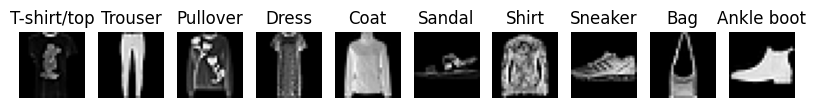

In [7]:
import random
fig, axs = plt.subplots(1, 10, figsize=(10, 2))

for class_idx in range(10):
    class_samples = [i for i, (_, label) in enumerate(train_set) if label == class_idx]
    random_sample_idx = random.choice(class_samples)
    image, _ = train_set[random_sample_idx]
    image = image.squeeze().numpy()
    axs[class_idx].imshow(image, cmap='gray')
    axs[class_idx].set_title(train_set.classes[class_idx])
    axs[class_idx].axis('off')

plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [8]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [9]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, class_count)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [10]:
def affine_forward(x, w, b):
    ## FILL HERE
    return  torch.matmul(x, w) + b

def relu(x):
    ## FILL HERE
    return torch.max(x, torch.zeros_like(x))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [11]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']
        x = affine_forward(x, w, b) # Matrix multiplication and bias addition
        if i < num_layers - 1:  # Apply activation function except for the last layer
            x = relu(x)
    return x

Implementing cross entropy loss:

In [12]:
def cross_entropy_loss(scores, y):
    n = len(y)
    if y.dim() == 1:
        y_vec = torch.zeros_like(scores)
        y_vec[range(n), y] = 1
    else:
        y_vec = y
    log_probs = torch.log(scores)
    loss = -torch.sum(y_vec * log_probs) / n
    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [13]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    ## FILL HERE
    for param_name, param_tensor in parameters.items():
        if param_tensor.grad is not None:
            # Update parameter using gradient descent
            param_tensor.data -= learning_rate * param_tensor.grad.data
            # Zero the gradients
            param_tensor.grad.data.zero_()

Training functions:

In [14]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    return (y_pred == y_true).sum() / len(y_true)

def train(train_loader, parameters, learning_rate=0.001, epoch=None):
    train_loss = 0
    N_train = len(train_loader.dataset)
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        # Manual calculation of cross-entropy loss
        log_prob = torch.log_softmax(p, dim=-1)
        loss = -torch.sum(log_prob[range(len(y)), y]) / len(y)

        train_loss += loss.item()
        loss.backward()
        sgd_optimizer(parameters, learning_rate)
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set in Epoch [{epoch+1}]: {acc:.4f}')
    train_loss /= len(train_loader)
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch

    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        ## FILL HERE

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [15]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [16]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders
    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, parameters, learning_rate, epoch)
        test_loss, test_acc = validate(test_loader, epoch, "test")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    # Plot the loss history of training and test sets
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Plot the accuracy history of training and test sets
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

Accuracy of train set in Epoch [1]: 0.3372
Accuracy of test set: 0.3825
Accuracy of train set in Epoch [2]: 0.3849
Accuracy of test set: 0.3539
Accuracy of train set in Epoch [3]: 0.4879
Accuracy of test set: 0.56265
Accuracy of train set in Epoch [4]: 0.6177
Accuracy of test set: 0.6572333333333333
Accuracy of train set in Epoch [5]: 0.6781
Accuracy of test set: 0.7116
Accuracy of train set in Epoch [6]: 0.7223
Accuracy of test set: 0.7513166666666666
Accuracy of train set in Epoch [7]: 0.7551
Accuracy of test set: 0.7625333333333333
Accuracy of train set in Epoch [8]: 0.7750
Accuracy of test set: 0.7858833333333334
Accuracy of train set in Epoch [9]: 0.7895
Accuracy of test set: 0.8007
Accuracy of train set in Epoch [10]: 0.8006
Accuracy of test set: 0.8002833333333333
Accuracy of train set in Epoch [11]: 0.8094
Accuracy of test set: 0.8104333333333333
Accuracy of train set in Epoch [12]: 0.8165
Accuracy of test set: 0.8231
Accuracy of train set in Epoch [13]: 0.8205
Accuracy of test

In [ ]:
print(f'Final test accuracy: {test_accuracies[-1]}')

## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

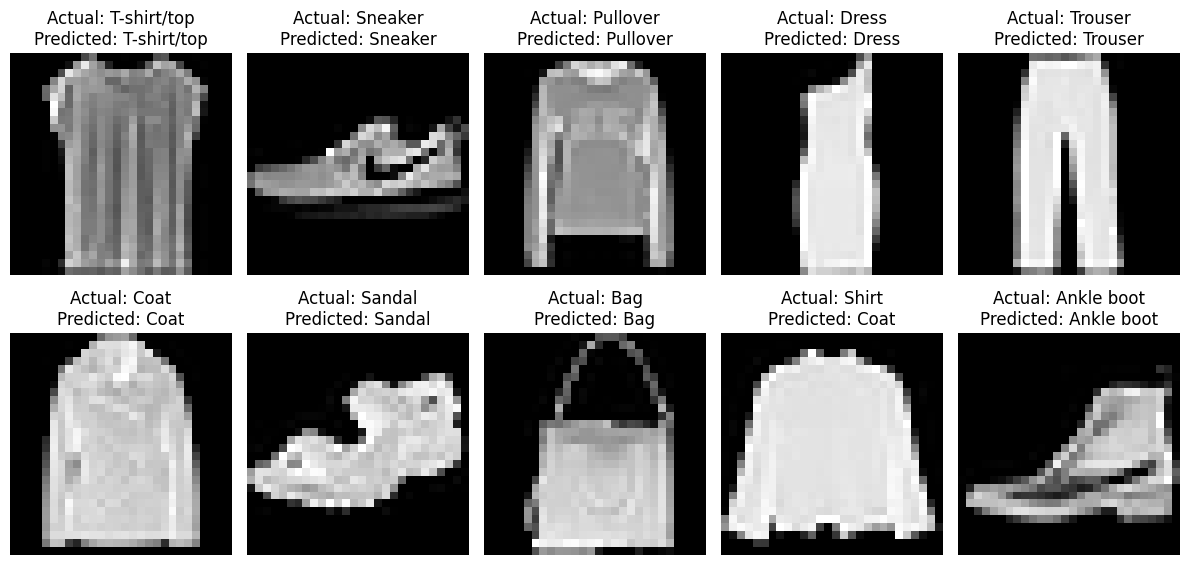

In [23]:
import torch
import matplotlib.pyplot as plt

def get_one_image_per_class(data_loader, model, parameters):
    images_per_class = {}
    labels_predictions = {}

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs, parameters)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(targets)):
                target = targets[i].item()

                if target not in images_per_class:
                    images_per_class[target] = inputs[i].cpu()
                    labels_predictions[target] = (targets[i].item(), predicted[i].item())

                if len(images_per_class) >= 10:
                    return images_per_class, labels_predictions

    return images_per_class, labels_predictions

def display_images(images_per_class, labels_predictions, class_names):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()

    for i, (class_label, image) in enumerate(images_per_class.items()):
        ax = axes[i]
        ax.imshow(image.squeeze(), cmap='gray')
        actual_label, predicted_label = labels_predictions[class_label]
        ax.set_title(f'Actual: {class_names[actual_label]}\nPredicted: {class_names[predicted_label]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
images_per_class, labels_predictions = get_one_image_per_class(test_loader, model, parameters)
class_names = test_loader.dataset.classes
display_images(images_per_class, labels_predictions, class_names)
